# Scipy vs our code

The `scipy` Gaussian kernel density estimation method is [documented here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde).  From reading the source code, and comparing with ["Density Estimation for Statistics and Data Analysis" by Silverman](https://books.google.co.uk/books?id=e-xsrjsL7WkC&lpg=PR9&ots=iwStts0DZr&dq=density%20estimation%20for%20statistics%20and%20data%20analysis&lr&pg=PP1#v=onepage&q=density%20estimation%20for%20statistics%20and%20data%20analysis&f=false) see equation 4.7 for example, the method is as follows.

- Input is $(X_i)_{i=1}^n$ points in a $d$-dimensional space, say each $X_i = (X^{(i)}_j)_{j=1}^d$
- Compute the covariance matrix from this sample:
$$ S_{j,k} = \frac{1}{n-1} \sum_i (X^{(i)}_j - \overline{X}_j)(X^{(i)}_k - \overline{X}_k) $$
where $\overline{X}_j = \frac{1}{n} \sum_i X^{(i)}_j$ is the sample mean of the $j$th coordinate.
- Letting $S^{-1}$ be the inverse matrix and $|S|$ the determinate of $S$, choose $h$, a "bandwidth", and $K$, a "symmetric kernel".  Then our density estimation is
$$ f(x) = \frac{1}{|S|^{1/2} h^d n} \sum_{i=1}^n K\big( h^{-2}  (X_i-x)^t S^{-1} (X_i-x) \big) $$
- For example, the Gaussian kernel gives $K(t) = (2\pi)^{-d/2} \exp(-t/2)$
- As stated by Silverman, this procedure is equivalent to applying a linear transformation to the input data so that it has unit covariance, forming the standard KDE, and then transforming back.
- The bandwidth can be chosen by eye, or we can use a "rule of thumb".  Here we follow `scipy` and use Scott's rule, which is $h = n^{-1/(4+d)}$.

### Some matrix algebra

The [covariance matrix](https://en.wikipedia.org/wiki/Covariance) $\Sigma(X)$ satisfies that if $A\in\mathbb M_n$ is a matrix, then $\Sigma(AX) = A \Sigma(X) A^T$.  As $\Sigma(X)$ is positive definite and invertible, we can find an invertible square-root $L$ with $L L^T = \Sigma(X)$ (e.g. use the [Cholesky Decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)).  Thus $\Sigma(L^{-1}X) = L^{-1} \Sigma(X) L^{-T} = L^{-1} L L^T L^{-T} = I$.

Now apply our KDE method to $Y = L^{-1}X$ to get say
$$ g(x) = \frac{1}{n h^d} \sum_{i=1}^n k(h^{-1}(x-Y_i)). $$
For example, $k(x) = (2\pi)^{-d/2} \exp(-x^Tx/2)$ the Gaussian kernel.  Then finally we set
$$ f(x) = |L^{-1}| g(L^{-1}x) = \frac{1}{n h^d} \sum_{i=1}^n k(h^{-1}(L^{-1}x-L^{-1}X_i)). $$
The $|L^{-1}|$ factor occurs to make sure that $f$ is a _normalised_ density.  Notice that $|L^{-1}| = |L|^{-1} = |\Sigma(X)|^{-1/2}$.  Assuming that $k(x) = K(x^Tx)$ for some $K$ (which is true for the Gaussian) we see that
$$ f(x) = \frac{|\Sigma(X)|^{-1/2}}{n h^d} \sum_{i=1}^n K(h^{-2} (x-X_i)^T \Sigma(X)^{-1} (x-X_i)), $$
as we claimed above.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.linalg

In [2]:
class GaussianKernel():
    """Expect input as array of shape `(d,N)` of `N` samples in `d`-dimensional space."""
    def __init__(self, data, bandwidth=None):
        self.data = np.asarray(data)
        if len(self.data.shape) == 0:
            raise ValueError("Cannot be a scalar")
        if len(self.data.shape) == 1:
            self.data = self.data[None,:]
        
        self.space_dims, self.num_data_points = self.data.shape
        if bandwidth is None:
            bandwidth = self._scott()
        
        self.covariance = np.atleast_2d(np.cov(data, rowvar=1, bias=False))
        self.inv_cov = scipy.linalg.inv(self.covariance) / (bandwidth**2)
        cdet = np.sqrt(scipy.linalg.det(self.covariance))
        
        self.normalisation = cdet * (2 * np.pi * bandwidth * bandwidth) ** (self.space_dims/2)
        self.normalisation *= self.num_data_points
        
    def _scott(self):
        return self.num_data_points ** (-1 / (4 + self.space_dims))
        
    def __call__(self, t):
        t = np.asarray(t)
        if len(t.shape) == 0:
            if self.space_dims != 1:
                raise ValueError("Expect {} dimensional input".format(space_dims))
            t = t[None]
        if len(t.shape) == 1:
            t = t[None,:]

        x = self.data[:,:,None] - t[:,None,:]
        x = np.sum(x * np.sum(self.inv_cov[:,:,None,None] * x[:,None,:,:], axis=0), axis=0)

        return np.sum(np.exp(-x / 2), axis=0) / self.normalisation

In [3]:
data = np.random.random(size=(2,20))
k = GaussianKernel(data)
kernel = scipy.stats.kde.gaussian_kde(data, bw_method="scott")

In [4]:
x = np.random.random(size=(2,100))
np.testing.assert_allclose(kernel(x), k(x))

In [5]:
data = np.random.random(size=20)
k = GaussianKernel(data)
kernel = scipy.stats.kde.gaussian_kde(data, bw_method="scott")

In [6]:
x = np.random.random(size=100)
np.testing.assert_allclose(kernel(x), k(x))

In [7]:
data = np.random.random(size=(3,20))
k = GaussianKernel(data)
kernel = scipy.stats.kde.gaussian_kde(data, bw_method="scott")

x = np.random.random(size=(3,100))
np.testing.assert_allclose(kernel(x), k(x))

# Stocastic declusting

To convert the "stocastic declusting" algorithm into a more "EM-like" algorithm, I would like to do the following:

- Start with data $(X_i)_{i=1}^m$ and a probability distribution on $\{1,2,\cdots,m\}$.
- Using the probability distribution, sample from the data, giving $(Y_i)_{i=1}^n$ say.
- Form the density estimate $f$ using $(Y_i)$.
- Thus $f$ is a random variable, and it makes sense to ask what the expectation of $f$ is (with respect to our probability distribution on $\{1,2,\cdots,m\}$).

This unfortunately seems rather computationally difficult:

- The covariance matrix is non-linear
- The normalisation factor $1/m$ is non-linear.  Even this alone seems hard to deal with: [Math.Stackoverflow question](https://math.stackexchange.com/questions/2357192/expectation-of-repeated-sampling)

Is this even correct?  Suppose we really have a _parametric_ distribution, for simplicity
$$ f(x; \mu) = \frac{1}{\sqrt{2\pi}} e^{-(x-\mu)^2/2} $$
i.e. a Gaussian with unknown mean.  The EM algorithm would look at log likelihood and in general boils down to calculations like
$$ \sum_{i=1}^n p_i \frac{\partial f / \partial \mu}{f} (x_i) = 0, $$
where $(x_i)$ are points, and we deem $x_i$ to have been chosen from the distribution with probability $p_i$ (and chosen from some other distribution with probability $1-p_i$).  What makes this work is that here we have linearity and so can use linearity of the expectation.

Continuing the example, we find that
$$ \sum_i p_i(x_i-\mu) = 0 \quad\Leftrightarrow\quad \mu = \sum_i p_ix_i. $$
So we end by estimating as the weighted sum of the $(x_i)$.

Alternatively, imagine sampling from the $(x_i)$ as before to get $(y_i)_{i=1}^k$ and then using the $(y_i)$ to estimate $\mu$: we get $\mu = \frac{1}{k} \sum_i y_i$.  Suppose we repeat this many times, and then take the average $\mu$.  What is this?  Well,
$$ \mathbb E(\mu) = \sum_{A\subseteq [n]} \prod_{i\in A} p_i \prod_{i\not\in A} (1-p_i) \frac{1}{|A|} \sum_{i\in A} x_i, $$
i.e. exactly what I asked in the Math.SO question.

Simple case: $n=2$.  Then we get
$$ (1-p_1)(1-p_2) 0 + p_1(1-p_2) x_1 + p_2(1-p_1) x_2 + \frac12 p_1p_2(x_1+x_2) 
= x_1 p_1\big(1-\frac12 p_2\big) + x_2 p_2\big(1-\frac12 p_1\big) $$

**Moral of the story:** These are simply not the same!

# Example: 1D mixture model

Sample $(X_i)_{i=1}^n$ where each $X_i$ is chosen from $N(\mu_0,1)$ or $N(\mu_1,1)$.

The EM algoritmn is to iterate these two steps:

1. Set, using the current estimates for $\mu_0, \mu_1$,
$$ p_{i,0} = \frac{e^{-(x_i-\mu_0)^2/2}}{e^{-(x_i-\mu_0)^2/2} + e^{-(x_i-\mu_1)^2/2}},
\qquad
p_{i,1} = \frac{e^{-(x_i-\mu_1)^2/2}}{e^{-(x_i-\mu_0)^2/2} + e^{-(x_i-\mu_1)^2/2}}. $$
2. Choose new estimates by
$$ \mu_0 = \frac{\sum_i p_{i,0} x_i}{\sum_i p_{i,0}},
\qquad
\mu_1 = \frac{\sum_i p_{i,1} x_i}{\sum_i p_{i,1}}. $$

In [158]:
N = 20
mu0, mu1 = 1, 5
actual0 = [i for i in range(N) if np.random.random() < 0.5]

x = []
for i in range(N):
    if i in actual0:
        x.append(np.random.normal(loc=mu0))
    else:
        x.append(np.random.normal(loc=mu1))
x = np.asarray(x)
x.sort()

### Via parameter estimation

In [159]:
def make_p(x, mu0, mu1):
    p0 = np.exp(-(x-mu0)**2/2)
    p1 = np.exp(-(x-mu1)**2/2)
    return np.vstack([p0 / (p0+p1), p1 / (p0+p1)])

def estimate_mu(x, p):
    return np.sum(p[0] * x) / np.sum(p[0]), np.sum(p[1] * x) / np.sum(p[1])

hatmu0 = 0
hatmu1 = 10

for _ in range(20):
    p = make_p(x, hatmu0, hatmu1)
    hatmu0, hatmu1 = estimate_mu(x, p)

hatmu0, hatmu1

(1.0272444383208252, 4.6669915189066877)

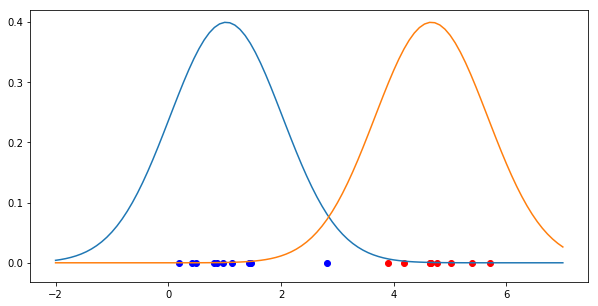

In [160]:
p = make_p(x, hatmu0, hatmu1)
class0 = p[0] < p[1]

fig, ax = plt.subplots(figsize=(10,5))

x0 = x[class0]
ax.scatter(x0, [0]*len(x0), color="red")
x1 = x[~class0]
ax.scatter(x1, [0]*len(x1), color="blue")

xx = np.linspace(-2, 7, 100)
ax.plot(xx, np.exp(-(xx-hatmu0)**2/2) / np.sqrt(2*np.pi))
ax.plot(xx, np.exp(-(xx-hatmu1)**2/2) / np.sqrt(2*np.pi))
None

### Stocastic declustering

At each stage, we use the current estimates of the kernels to build the probability density of the "hidden variables", and then sample: this makes a random choice for which class each point is in, given the current kernels.

Using this random choice, we use `scipy.kde` to build new estimates for kernels, and then repeat.

This actually doesn't perform as well as we might hope: it does fine for small datasets, but tends to converge to the kernels being equal sometimes...

In [161]:
x0 = [x < np.mean(x)]
x1 = [x >= np.mean(x)]

for _ in range(1000):
    k0 = scipy.stats.kde.gaussian_kde(x0)
    k1 = scipy.stats.kde.gaussian_kde(x1)
    
    p0, p1 = k0(x), k1(x)
    p = np.vstack([p0/(p0+p1), p1/(p0+p1)])
    
    choice = np.random.random(size=len(x)) <= p[0]
    x0 = x[choice]
    x1 = x[~choice]

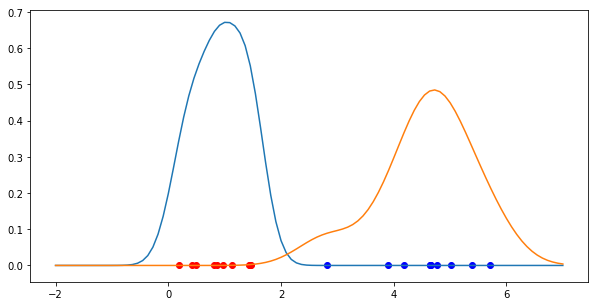

In [162]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x0, [0]*len(x0), color="red")
ax.scatter(x1, [0]*len(x1), color="blue")

xx = np.linspace(-2, 7, 100)
ax.plot(xx, k0(xx))
ax.plot(xx, k1(xx))
None

### Stocastic declustering with repeatition

At each stage, instead of taking one sample, we take many samples, compute many kernels, and then take the average.

This suffers from the problem above, but only more so: if there is not a good "gap" between the two sets, we tend to find poor convergence.

In [163]:
def combine(kernels):
    def kernel(t):
        return np.mean(np.asarray([k(t) for k in kernels]), axis=0)
    return kernel

def make_kernels(x, p, samples=100):
    k0, k1 = [], []
    for _ in range(samples):
        choice = np.random.random(size=len(x)) <= p[0]
        x0 = x[choice]
        x1 = x[~choice]
        k0.append(scipy.stats.kde.gaussian_kde(x0))
        k1.append(scipy.stats.kde.gaussian_kde(x1))
    return combine(k0), combine(k1)

In [164]:
p0 = np.array(x < np.mean(x), dtype=np.int)
p1 = np.array(x >= np.mean(x), dtype=np.int)
p = np.vstack([p0/(p0+p1), p1/(p0+p1)])

for _ in range(1000):
    k0, k1 = make_kernels(x, p)
    
    p0, p1 = k0(x), k1(x)
    p = np.vstack([p0/(p0+p1), p1/(p0+p1)])

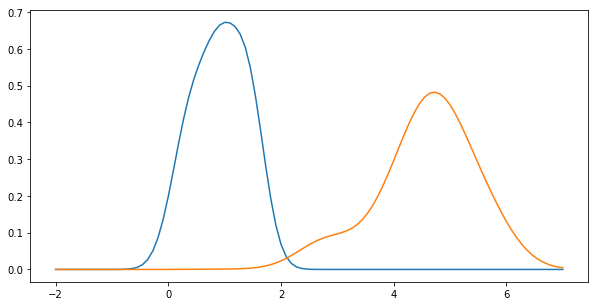

In [165]:
fig, ax = plt.subplots(figsize=(10,5))

xx = np.linspace(-2, 7, 100)
ax.plot(xx, k0(xx))
ax.plot(xx, k1(xx))

None

### Mixed KDE

Here we try our rather tentative idea of using the probability "weights" directly in the KDE construction.  This suffers from the same problem: we converge to the case of no mixture.

In [166]:
def kde(x, p, training):
    # `training` used only for bandwidth selection.
    s = np.var(training, ddof=1)
    scott = len(training) ** (-1 / 5)
    band = 1 / (s * scott * scott)
    norm = np.sqrt(band / (2 * np.pi)) / np.sum(p)
    def kernel(t):
        t = np.asarray(t)
        if len(t.shape) == 0:
            t = t[None]
        xx = (x[:,None]-t[None,:])**2 * band
        return np.sum(p[:,None] * np.exp(-xx/2), axis=0) * norm
    return kernel

In [167]:
p0 = np.array(x < np.mean(x), dtype=np.int)
p1 = np.array(x >= np.mean(x), dtype=np.int)
p = np.vstack([p0/(p0+p1), p1/(p0+p1)])

for _ in range(10000):
    k0 = kde(x, p[0], x[p[0] > 0.1])
    k1 = kde(x, p[1], x[p[1] > 0.1])

    p0, p1 = k0(x), k1(x)
    p = np.vstack([p0/(p0+p1), p1/(p0+p1)])

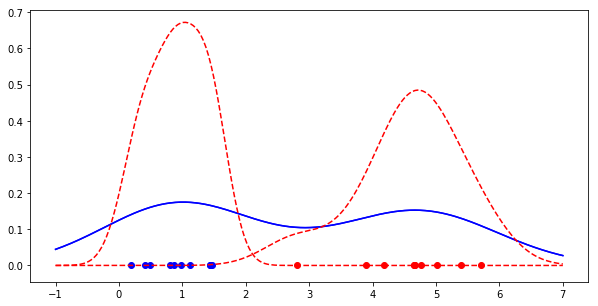

In [168]:
fig, ax = plt.subplots(figsize=(10,5))

class0 = p[0] < p[1]
x0 = x[class0]
ax.scatter(x0, [0]*len(x0), color="red")
x1 = x[~class0]
ax.scatter(x1, [0]*len(x1), color="blue")

xx = np.linspace(-1, 7, 200)
ax.plot(xx, k0(xx), color="blue")
ax.plot(xx, k1(xx), color="blue")

kk0 = scipy.stats.kde.gaussian_kde(x0)
ax.plot(xx, kk0(xx), linestyle="--", color="red")
kk1 = scipy.stats.kde.gaussian_kde(x1)
ax.plot(xx, kk1(xx), linestyle="--", color="red")
None